In [1]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')
gdrive_path = os.getcwd()

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import scipy.stats as stats
import operator
from sklearn.metrics import roc_curve, auc
import random
import warnings
warnings.filterwarnings('ignore')

In [26]:
#Reading the data
#Enter the input file here
file_path = path = Path.cwd() / "FOM_MA" / "Kaggle_Claims" / "data" / "train.csv"
#'/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/train.csv'
train_df = pd.read_csv(file_path)
n = 7000#number of rows from the dataframe
train_data_points = 1000 # number of training data points
#deleting the column 'id' from the dataframe as it is a unique and does not have any effect on the algorithm
del train_df['id']
#print (train_df.head())

In [27]:
#creating 2 seperate dataframes for categorical and continuous features.
train_df_cat = pd.DataFrame()#training data frame with categorical features
train_df_cont = pd.DataFrame() #training data with continuous features
cat_list = []#list of categorical features
cont_list = []#list of continuous features

#populating the created data frames for categorical and continuous features
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'float':
        cont_list.append(each_column)
cont_list.remove('loss')
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'object':
        cat_list.append(each_column)

for i in range(0,len(cat_list)):
    train_df_cat[i] = train_df[cat_list[i]]
train_df_cat.columns =cat_list
for i in range(0,len(cont_list)):
    train_df_cont[i] = train_df[cont_list[i]]
train_df_cont.columns =cont_list

In [28]:

#checking for missing values:
print ("The total missing values in data",train_df.isnull().sum().sum())
#sum is 0 which indicates there are no misisng values in the training data.

The total missing values in data 0


In [29]:
train_df.sample(3)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
2832,A,A,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,E,A,P,M,A,A,A,E,F,J,H,B,BI,CO,A,E,AS,E,L,DF,0.314050,0.620805,0.506105,0.383428,0.372405,0.252511,0.279001,0.50060,0.33611,0.31480,0.278556,0.289207,0.333292,0.820532,2786.09
122214,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,...,A,C,D,D,E,C,A,P,G,A,A,B,G,H,G,F,B,BI,EB,A,J,AX,C,J,HK,0.496063,0.681761,0.792378,0.432728,0.551723,0.456946,0.589494,0.31280,0.44352,0.53328,0.771508,0.758883,0.336261,0.381338,1657.80
64101,B,B,A,B,B,A,A,A,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,C,E,A,D,T,I,G,A,B,K,F,F,K,K,BI,EG,E,S,L,A,O,LM,0.614340,0.199504,0.230975,0.705434,0.281143,0.789730,0.633655,0.82252,0.58325,0.80218,0.757468,0.744640,0.818567,0.679235,1189.70


In [30]:
#Korrelation
corr_matrix = train_df.corr()
corr_matrix["loss"].sort_values(ascending = False)

loss      1.000000
cont2     0.141528
cont7     0.119799
cont3     0.111053
cont11    0.099806
cont12    0.098724
cont6     0.040967
cont8     0.030508
cont10    0.020236
cont14    0.019298
cont9     0.014456
cont13   -0.004022
cont1    -0.010237
cont5    -0.011355
cont4    -0.035831
Name: loss, dtype: float64

In [32]:
feature_list = []

train_df_best_features = pd.DataFrame()
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'float':
        feature_list.append(each_column)

best_features_train_df = pd.DataFrame()
for i in range(0,len(feature_list)):
    best_features_train_df[i] = train_df[feature_list[i] ]
best_features_train_df.columns =feature_list
print(best_features_train_df.shape)

(188318, 15)


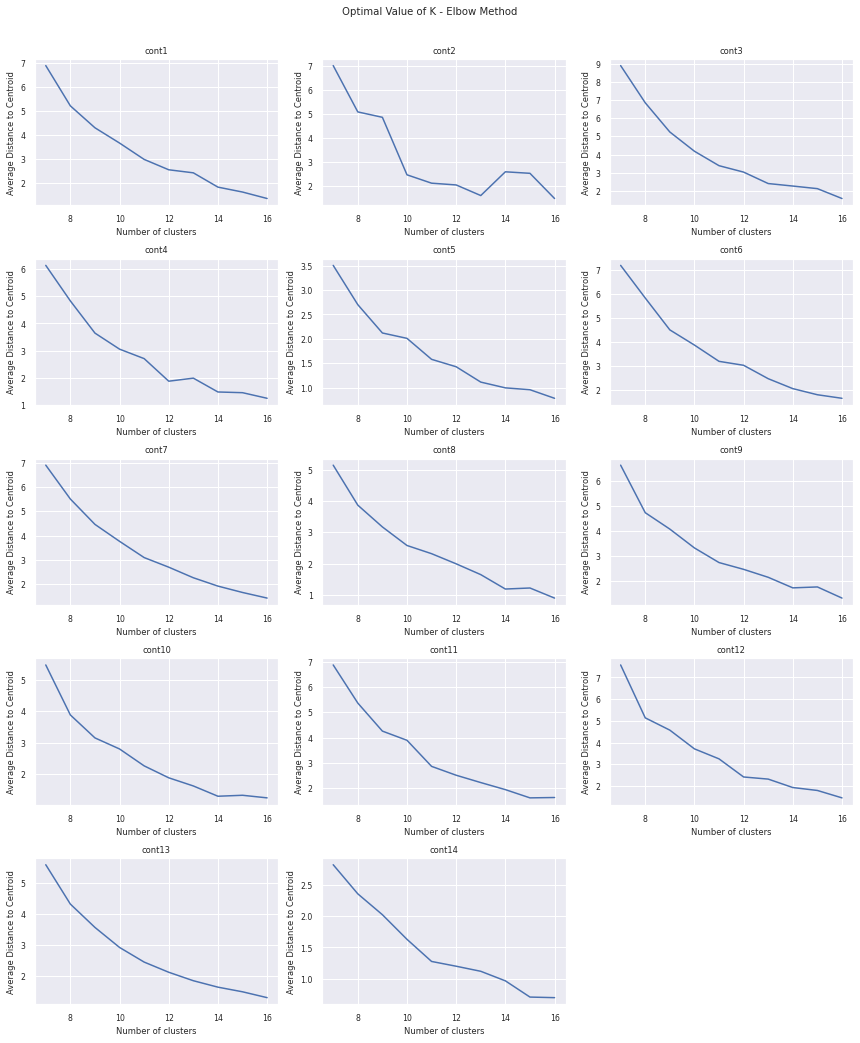

(7000, 14)


In [33]:
best_features_train_df =  best_features_train_df[:n]#nused
del best_features_train_df['loss']
#using elbows method to find the optimal value of k
from sklearn.cluster import KMeans,MiniBatchKMeans
from scipy.spatial.distance import cdist,pdist

count = 1
plt.figure(figsize = (12,14))
for each_column in best_features_train_df.columns:
    range_to_be_tested = range(7,17)
    feature_reconfigured = best_features_train_df[each_column].values.reshape(-1, 1)

    model_fit = [KMeans(n_clusters = n,init = 'random',n_init=10).fit(feature_reconfigured) for n in range_to_be_tested]
    cluster_centers = [each_model.cluster_centers_ for each_model in model_fit]
    #print (len(cluster_centers))
    #print (cluster_centers)
    euc_distance = [cdist(feature_reconfigured,each_center,'euclidean') for each_center in cluster_centers]   
    min_distance = [np.min(each_distance,axis = 1) for each_distance in euc_distance]
    #Calcuating the total sum of squares (SSE):

    tsse = sum(pdist(feature_reconfigured)**2)/feature_reconfigured.shape[0]
    #print ("tsse",tsse)
    #print (kmeans_optimal.inertia_)
    #calculating the sse between the clusters:
    wsse = [sum (eac_dist **2) for eac_dist in min_distance]
    bsse = tsse - wsse
    #print (wsse)
    y_axis = wsse  #bsse/tsse
    #print (bsse)
    #print (bsse/tsse)
    cluster_variance_dict = dict(zip(range(7,17),y_axis))
    #print ("The dictionary with number of clusters as key and the variance as value",cluster_variance_dict)
    
    plt.subplot(5, 3, count)
    count += 1
    plt.plot(range(7,17),y_axis)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Distance to Centroid')
    plt.title(each_column)
plt.suptitle('Optimal Value of K - Elbow Method', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/kmeans.png")
plt.show()

#On analysing in all the 14 continuous features the variance stabilizes at 13 or 14 clusters. It makes sense because all 
#continuous features has values in the similar range. Hence choosing 13 clusters.

#In this case we also considered the effect of choosing initial centroids. By setting the parameter n_init = 10,
#each feature is clustered with 10 different value of initial centroids for each value of k, and the initial seed with 
#minimum sse is chosen.

print(best_features_train_df.shape)

In [34]:
#Now that we have decided the optimal number of clusters for each feature, lets discretize the features.

from sklearn.cluster import KMeans,MiniBatchKMeans

print ("Before Clustring:")
print (best_features_train_df.head())

for each_column in best_features_train_df.columns:
    if each_column == 'cont4' or each_column == 'cont5' or each_column == 'cont6' or each_column == 'cont10' or each_column == 'cont11' or each_column == 'cont13':
        ftre = best_features_train_df[each_column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters = 13,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_
    else:
        ftre = best_features_train_df[each_column].values.reshape(-1, 1)
        kmeans = KMeans(n_clusters = 12,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_

#print (best_features_train_df.head())
print ('\t')
print ("After Clustring:")
print (best_features_train_df.head())

Before Clustring:
      cont1     cont2     cont3  ...    cont12    cont13    cont14
0  0.726300  0.245921  0.187583  ...  0.594646  0.822493  0.714843
1  0.330514  0.737068  0.592681  ...  0.366307  0.611431  0.304496
2  0.261841  0.358319  0.484196  ...  0.373424  0.195709  0.774425
3  0.321594  0.555782  0.527991  ...  0.321570  0.605077  0.602642
4  0.273204  0.159990  0.527991  ...  0.202213  0.246011  0.432606

[5 rows x 14 columns]
	
After Clustring:
   cont1  cont2  cont3  cont4  cont5  ...  cont10  cont11  cont12  cont13  cont14
0     10      4     10      9      1  ...      11       0       8       2       6
1      1      3      4      7      9  ...      10       7       1       9       8
2      2      2      7     11      7  ...       2       8       1       4      10
3      1     11      8      6      7  ...      10       7       5       9       2
4      2      7      8      3     10  ...       9       9       7       4      11

[5 rows x 14 columns]


In [38]:
res = train_df[:n]['loss'].astype(int)
res.mean() 

3059.5717142857143

In [39]:
best_features_train_df = best_features_train_df.astype('str')
column_list = best_features_train_df.columns
#print (best_features_train_df.shape)

train_df_cat_reduced = train_df_cat[:n] #nused
#Here will be the code to merge the clustered data frames after one hot encoding.

print ("Before Binarization:")
print ('\t')
print (train_df_cat_reduced.head())
for each_column in column_list:
    train_df_cat_reduced[each_column] = best_features_train_df[each_column]
    
#df_mod_onehotencoded will be the pre processed complete data including test and train
df_mod_onehotencoded = pd.get_dummies(train_df_cat_reduced)
df_mod_onehotencoded['loss'] = train_df[:n]['loss'] #nused
df_mod_onehotencoded = df_mod_onehotencoded.astype(int)

for index,each_row in df_mod_onehotencoded.iterrows():
    if each_row['loss'] < 2115.57:
        each_row['loss'] = 0
    else:
         each_row['loss'] = 1 #tobereplaced
df_mod_onehotencoded['loss'] = df_mod_onehotencoded['loss'].astype(int)
print ("After Binarization:")
print (df_mod_onehotencoded.head())

Before Binarization:
	
  cat1 cat2 cat3 cat4 cat5 cat6  ... cat111 cat112 cat113 cat114 cat115 cat116
0    A    B    A    B    A    A  ...      C     AS      S      A      O     LB
1    A    B    A    A    A    A  ...      A     AV     BM      A      O     DP
2    A    B    A    A    B    A  ...      A      C     AF      A      I     GK
3    B    B    A    B    A    A  ...      C      N     AE      A      O     DJ
4    A    B    A    B    A    A  ...      C      Y     BM      A      K     CK

[5 rows x 116 columns]
After Binarization:
   cat1_A  cat1_B  cat2_A  cat2_B  ...  cont14_7  cont14_8  cont14_9  loss
0       1       0       0       1  ...         0         0         0     1
1       1       0       0       1  ...         0         1         0     0
2       1       0       0       1  ...         0         0         0     1
3       0       1       0       1  ...         0         0         0     0
4       1       0       0       1  ...         0         0         0     1

[5 rows 

In [42]:
df_mod_onehotencoded[df_mod_onehotencoded["loss"] !=0].count(),df_mod_onehotencoded[df_mod_onehotencoded["loss"] == 0].count()

(cat1_A      3518
 cat1_B      3518
 cat2_A      3518
 cat2_B      3518
 cat3_A      3518
             ... 
 cont14_6    3518
 cont14_7    3518
 cont14_8    3518
 cont14_9    3518
 loss        3518
 Length: 1051, dtype: int64, cat1_A      3482
 cat1_B      3482
 cat2_A      3482
 cat2_B      3482
 cat3_A      3482
             ... 
 cont14_6    3482
 cont14_7    3482
 cont14_8    3482
 cont14_9    3482
 loss        3482
 Length: 1051, dtype: int64)

The number of data points are:
{0: 3482, 1: 3518}


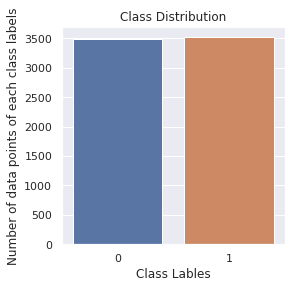

In [44]:
#We can see that the dataset is almost balanced
import seaborn as sns
y = df_mod_onehotencoded[['cat1_A','loss']].groupby("loss").count().values.tolist()
x = df_mod_onehotencoded[['cat1_A','loss']].groupby("loss").count().index.tolist()
for i in range(len(y)):
            y[i] = y[i][0]
print ("The number of data points are:")
print (dict(zip(x,y)))
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(figsize = (4,4))
sns.set(font_scale =  1)
sns.barplot(x, y,label = "big")
plt.title("Class Distribution")
plt.xlabel('Class Lables')
plt.ylabel('Number of data points of each class labels')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/class_dist.png")
plt.show()

In [22]:
#Now that we have binarized the data using the one hot encoding, we have the data in the required format
#The next step is to apply feature selection and the machine learning algorithm

from sklearn.model_selection import train_test_split
#getting the target column into a seperate dataframe
target_df = pd.DataFrame()
target_df ['loss'] = df_mod_onehotencoded['loss']
#Hence deleting the target column from the features data frame
del df_mod_onehotencoded['loss']
#splitting tha training data and testing data
# use train/test split with different random_state values
x_train, x_test, y_train, y_test = train_test_split(df_mod_onehotencoded, target_df, random_state=10)
#print (x_train.shape)
#print (y_train.shape)
#print (x_test.columns)

The top features with CHI- Square Feature selection


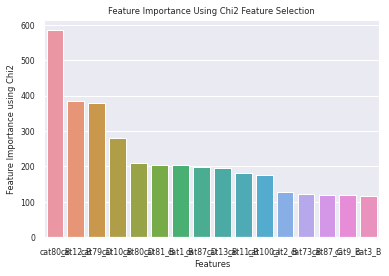

In [23]:
#Before applying the algorithm we will check the class balance in the data.
from math import isnan
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
chisqobj = SelectKBest(chi2, k=2)
fit = chisqobj.fit(x_train, y_train)
value_dict = dict(zip(df_mod_onehotencoded.columns,fit.scores_))
value_dict = {k: value_dict[k] for k in value_dict if not isnan(value_dict[k])}
sorted_important_features_list  = sorted(value_dict, key=value_dict.get,reverse = True)
#print (sorted_important_features_list)
#We have the list of the features, arranged in decsending order, i.e the feature with the maximum score will be the 
#first element in the list and so on.
#print (y_train.shape)
feature_list = [];feature_scores = [];
for i in range(0,16):
    feature_list.append(sorted_important_features_list[i])
    feature_scores.append(value_dict[sorted_important_features_list[i]])
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
sns.set(font_scale =  .7)
sns.barplot(feature_list, feature_scores,label = "big")
print ("The top features with CHI- Square Feature selection")
plt.title("Feature Importance Using Chi2 Feature Selection")
plt.xlabel('Features')
plt.ylabel('Feature Importance using Chi2')
#plt.savefig('/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/chi2_ftre_imp.png')
plt.show()


#print (sorted_important_features_list)

The max accuracy for 100 top features 0.7106666666666667
The max accuracy for 200 top features 0.7234285714285714
The max accuracy for 300 top features 0.7121904761904763
The max accuracy for 400 top features 0.7
The max accuracy for 500 top features 0.6895238095238095
The max accuracy for 600 top features 0.6876190476190476
The max accuracy for 700 top features 0.6716190476190476


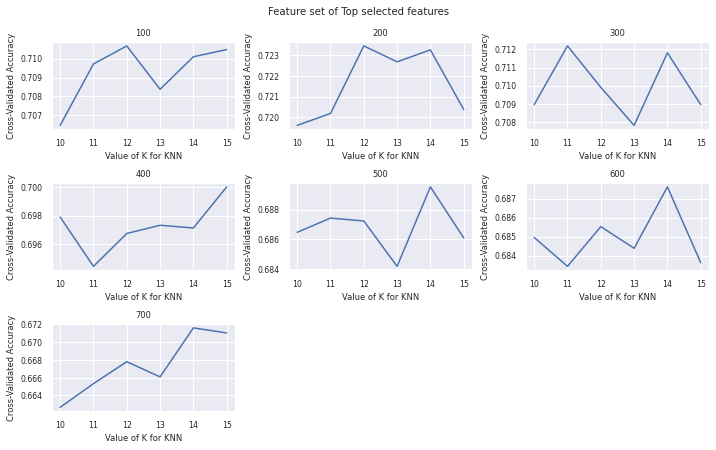

The top subset of features are: 200


In [25]:
#In the feature selection was not able to select the t - top features because, choosing k randomly might affect the 
#accuracy of the algorithm. We will now apply the k nn algorithm and select the optimal value of t(top features)
#and k (number of nearest neighbours using tuning set)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import  cross_val_score
ftre_list = [];score_list = [];
count = 1
plt.figure(figsize = (10,6))
for i in range(100,800,100):
    features = sorted_important_features_list[:i]
    #print ("here1")
    k_range = range(10, 16)
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm='auto')      
        scores = cross_val_score(knn, x_train[features].values, y_train['loss'].values, cv=10, scoring='accuracy')
        #print ("here2")
        k_scores.append(scores.mean())
        #print ("here3")
    print("The max accuracy for",i,"top features",max(k_scores))
    ftre_list.append(str(i))
    score_list.append(max(k_scores))
    #print ("here4")
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_optimal_finder.png")
plt.show()
ftre_select_dict = dict(zip(ftre_list,score_list))

selected_ftre_count = int (max(ftre_select_dict, key=ftre_select_dict.get))
print ("The top subset of features are:",selected_ftre_count)